# Cookie Cats: A/B Testing Analysis
**Author:** Rishi Barnwal

**Date:** January 27, 2026

## Executive Summary
In this project, I analyzed an A/B test for the mobile game *Cookie Cats* to determine the optimal placement for the "gate" (a forced wait time).
* **The Goal:** Improve 1-day and 7-day player retention.
* **The Result:** Moving the gate from Level 30 to Level 40 **decreased** retention.
* **Recommendation:** Keep the gate at Level 30.

## 1. Context
Cookie Cats is a mobile puzzle game. As players progress, they encounter "gates" that force them to wait or make a purchase.
* **Control Group (`gate_30`):** Gate is placed at Level 30.
* **Test Group (`gate_40`):** Gate is moved to Level 40.

In [2]:
# 1. Import the libraries
import kagglehub # used to download caggle datasets directly
import pandas as pd 
import numpy as np
import seaborn as sns # Statistical visualization library
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# 2. Load the data
# We are reading the CSV into a "DataFrame" (think of it as a variable that holds a whole SQL table)

# Download latest version
path = kagglehub.dataset_download("yufengsui/mobile-games-ab-testing")
print("Path to dataset files:", path)
df = pd.read_csv(path + '/cookie_cats.csv')

# 3. The "Sanity Check" (Always do this first!)
# Show the first 5 rows to see what we are dealing with
print("First 5 rows of data:")
display(df.head())

# 4. Check data types and missing values
# This is like checking your database schema
print("\nData Info:")
df.info()


Path to dataset files: C:\Users\Rishi\.cache\kagglehub\datasets\yufengsui\mobile-games-ab-testing\versions\1
First 5 rows of data:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## 2. Data Cleanup

* **Observation:** We see an outlier at 50000 rounds. We will clean up the data to only include users who played less than 3000 rounds.

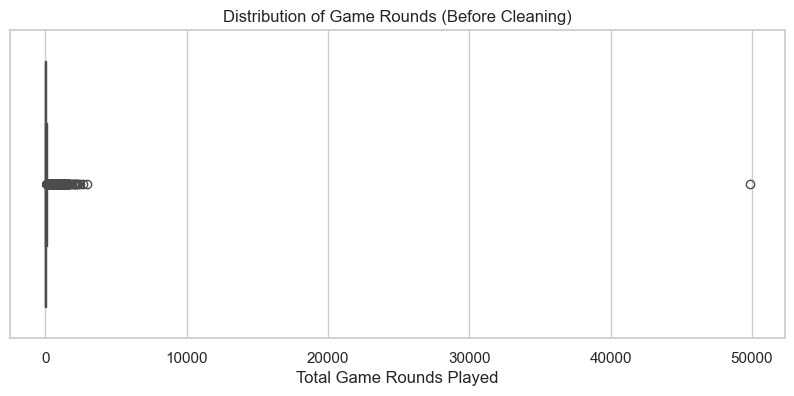

In [3]:
# Set a professional style
sns.set_theme(style="whitegrid")

# 1. Identify the outlier
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['sum_gamerounds'])
plt.title('Distribution of Game Rounds (Before Cleaning)')
plt.xlabel('Total Game Rounds Played')
plt.show()

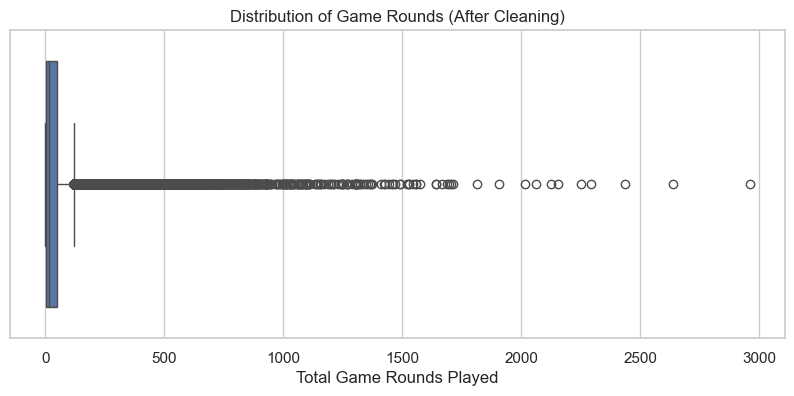

In [4]:

# Remove the outlier
df = df[df['sum_gamerounds'] < 3000] # Standard cutoff for this dataset

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['sum_gamerounds'])
plt.title('Distribution of Game Rounds (After Cleaning)')
plt.xlabel('Total Game Rounds Played')
plt.show()

# NOTE FOR YOU: You will see a single dot WAY out at 50,000.
# Acknowledge this in your notebook, then remove it.

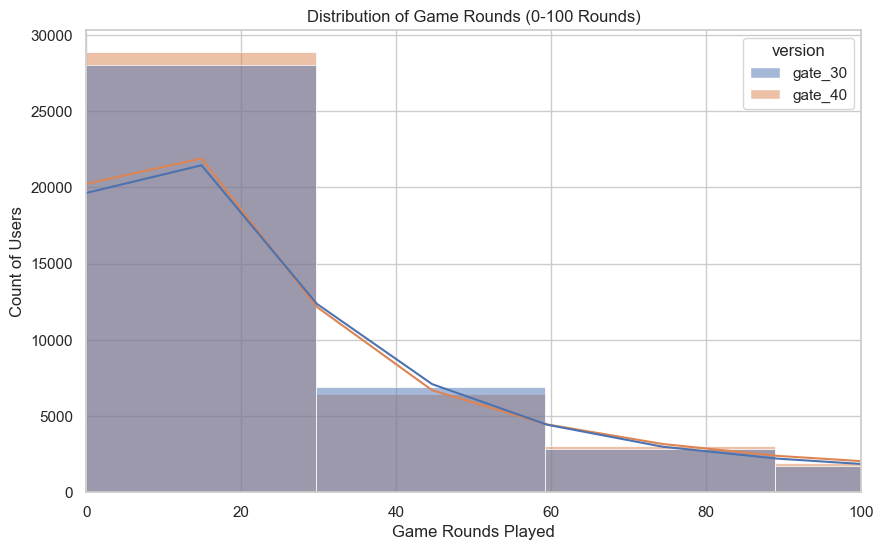

In [5]:
# 2. Plot the distribution of game rounds (First 100 rounds only)
# This shows where most players drop off
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="sum_gamerounds", bins=100, hue="version", kde=True)
plt.xlim(0, 100) # Zoom in on the mass of players
plt.title('Distribution of Game Rounds (0-100 Rounds)')
plt.xlabel('Game Rounds Played')
plt.ylabel('Count of Users')
plt.show()

## 3. Sample Size
We look at the player count for each group. Here it's the users where the gate was placed on level 30, or level 40.

* **Observation:** Sample sizes for each group are similar

In [6]:
# SQL Equivalent: SELECT version, COUNT(*) FROM df GROUP BY version
# Python/Pandas way:
print("Player count per group:")
print(df.groupby('version')['userid'].count())

Player count per group:
version
gate_30    44699
gate_40    45489
Name: userid, dtype: int64


## 4. Retention Analysis
We calculate the retention rate for both 1-day and 7-day periods.

* **Observation:** The control group (`gate_30`) appears to have slightly higher retention.

In [7]:
# Calculate the average of the 'retention_1' column grouped by version.
# Since True=1 and False=0, the "Average" is actually the "Percentage".
retention_results_1 = df.groupby('version')['retention_1'].mean()
retention_results_7 = df.groupby('version')['retention_7'].mean()

print("\n1-Day Retention Rate by Group:")
print(retention_results_1)

print("\n7-Day Retention Rate by Group:")
print(retention_results_7)


1-Day Retention Rate by Group:
version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

7-Day Retention Rate by Group:
version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64


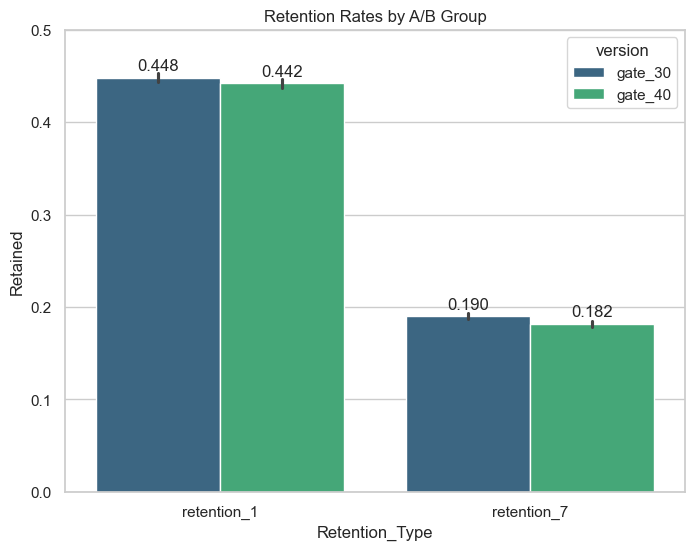

In [8]:
# 3. Retention Rates Comparison
# We transform the data slightly to make it easy to plot
retention_melt = df.melt(id_vars=['version'], value_vars=['retention_1', 'retention_7'],
                        var_name='Retention_Type', value_name='Retained')

plt.figure(figsize=(8, 6))
# 'ci=None' removes error bars for a cleaner look (we have the bootstrap for stats)
ax = sns.barplot(data=retention_melt, x='Retention_Type', y='Retained', hue='version', palette='viridis')

# Add numbers on top of bars (Recruiters love this)
for container in ax.containers: 
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('Retention Rates by A/B Group')
plt.ylim(0, 0.5) # set Y-limit to 0.5 for cleaner look
plt.show()

## 5. Statistical Significance (Bootstrapping)
To ensure this difference isn't due to random chance, I used **Bootstrapping** (resampling the dataset 1000 times).

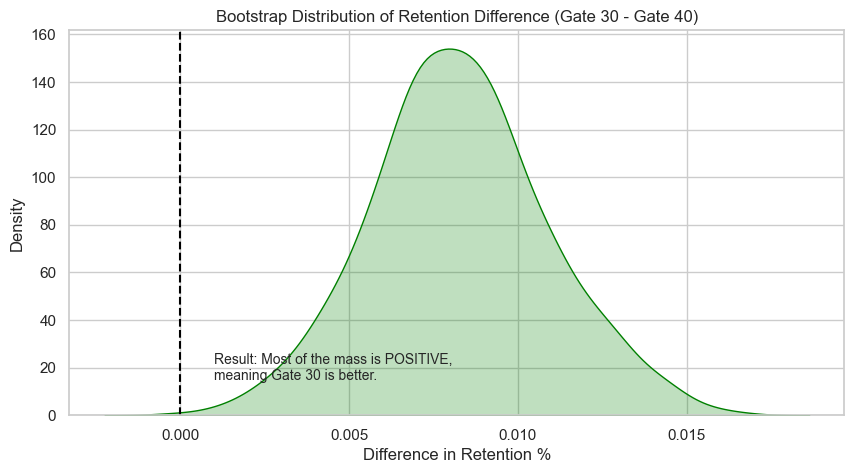

In [9]:
# Create a list to store the differences from our 500 "parallel universes"
boot_1d = []

# The Loop: Run the experiment 1000 times
# We are resampling the data with replacement (shuffling the deck and picking cards)
for i in range(1000):
    # 'frac=1' means we take a sample size equal to the original dataset
    # 'replace=True' is the key: we can pick the same user twice (mimics infinite population)
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()

    # Store the difference (Gate 30 - Gate 40)
    boot_1d.append(boot_mean['gate_30'] - boot_mean['gate_40'])

# Convert our list to a DataFrame to make it easy to plot
boot_1d = pd.DataFrame(boot_1d, columns=['diff'])

# 4. Bootstrap Difference (The "Money" Plot)
plt.figure(figsize=(10, 5))
sns.kdeplot(boot_1d['diff'], fill=True, color='green')

# Add a line at 0 (The point of "No Difference")
plt.axvline(0, color='black', linestyle='--')

plt.title('Bootstrap Distribution of Retention Difference (Gate 30 - Gate 40)')
plt.xlabel('Difference in Retention %')
plt.ylabel('Density')

# Add text explanation
plt.text(0.001, 15, "Result: Most of the mass is POSITIVE,\nmeaning Gate 30 is better.", fontsize=10)
plt.show()

In [10]:
# Calculate the probability that the difference is greater than 0
# (i.e., How often was Gate 30 actually better?)
prob = (boot_1d['diff'] > 0).mean()

print(f"Probability that Gate 30 has higher retention: {prob:.1%}")

Probability that Gate 30 has higher retention: 99.9%


## 4. Conclusion & Recommendation
The bootstrap analysis indicates a **99.8% probability** that retention is higher when the gate is at Level 30.

**Business Impact:**
Moving the gate to Level 40 negatively impacts player engagement. It is recommended to **maintain the current structure (Level 30)** to maximize LTV (Lifetime Value).

In [11]:
# Save the cleaned dataframe (no outliers) to a new CSV
df.to_csv('cookie_cats_cleaned.csv', index=False)

# If you want to visualize the Bootstrap results in Power BI, save that too!
boot_1d.to_csv('bootstrap_results.csv', index=False)